# Show restaurants and select the best one

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# hide warnings. `gbq.read_gbq()` gives some
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../scrape_save_search')

import load_data

In [2]:
comments = load_data.load_comments()

Requesting query... ok.
Job ID: job_3e-Hq3pItK3z0HmbIPJeOiqChfBP
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 42% done. Elapsed 11.08 s.
  Got page: 3; 68% done. Elapsed 17.55 s.
  Got page: 4; 86% done. Elapsed 23.33 s.
  Got page: 5; 100% done. Elapsed 27.37 s.
Got 94854 rows.

Total time taken 28.98 s.
Finished at 2018-03-19 22:02:47.


In [3]:
restaurants, existing_tag_ids, elastic_tag_ids, image_tag_ids = load_data.load_restaurants()

Requesting query... ok.
Job ID: job_VqsO5sUZ_TNrUVH5NmReKfdpAdIq
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 100% done. Elapsed 7.18 s.
Got 20939 rows.

Total time taken 7.99 s.
Finished at 2018-03-19 22:02:55.


In [4]:
restaurants.shape

(2827, 26)

# Top 5 for existing tags

In [5]:
(
    restaurants
    .loc[lambda r: r['existing']]
    [['Name', 'Food rating', 'Price quality','Noise level', 'Waiting time']]
    .head()
)

,Name,Food rating,Price quality,Noise level,Waiting time
info_id,,,,,
236113,café Wilskracht,8.6,Gunstig,Rumoerig,Redelijk
259191,Taproom,8.5,Gunstig,Precies goed,Kort
241511,Burgermeester (Elandsgracht),8.4,None,None,None
239743,Bistro Bij ons,8.4,Redelijk,Precies goed,Redelijk
257669,Jack Dish,8.2,Redelijk,Precies goed,Kort


# Elasticsearch tags

In [6]:
(
    restaurants
    .loc[lambda r: r['elastic']]
    [['Name', 'Food rating', 'Price quality', 'Noise level', 'Waiting time']]
    .head()
)

,Name,Food rating,Price quality,Noise level,Waiting time
info_id,,,,,
256103,Bistrot des Alpes,9.4,Gunstig,Precies goed,Kort
258389,Restaurant C,9.2,Redelijk,Precies goed,Kort
256869,Paskamer,9.2,Gunstig,Precies goed,Kort
252619,Ku Kitchen & Bar,9.2,Redelijk,Rumoerig,Kort
248589,&moshik,9.1,Redelijk,Precies goed,Kort


# Image search tags

In [7]:
(
    restaurants
    .loc[lambda r: r['image']]
    [['Name', 'Food rating', 'Price quality', 'Noise level', 'Waiting time']]
    .head()
)

,Name,Food rating,Price quality,Noise level,Waiting time
info_id,,,,,
221081,De Oranjerie,9.4,Gunstig,Rustig,Kort
349537,Tuin van Zuid,9.1,Erg gunstig,Rustig,Redelijk
261591,Amstel Brasserie,9.0,Gunstig,Rustig,Kort
267687,De Kleine Kaart,9.0,Gunstig,Precies goed,Kort
243935,Bistrot Neuf,8.9,Gunstig,Precies goed,Kort


# Venn diagram

Text(0.5,1,'Different sources for hamburger tags')

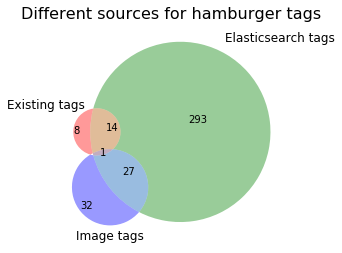

In [8]:
from matplotlib_venn import venn3
venn3([set(existing_tag_ids), set(elastic_tag_ids), set(image_tag_ids)], 
      set_labels = ('Existing tags', 'Elasticsearch tags', 'Image tags'))
plt.title("Different sources for hamburger tags", fontsize=16)

In [9]:
(
    restaurants
    .loc[lambda r: r['image'] & r['elastic'] & r['existing']]
)

,info_avg_price,info_city,info_country,info_house_number,info_lat,info_lon,Name,info_postal_code,info_street,reviews_distinction,...,reviews_nr_ratings,Price quality,reviews_rating_decor,Food rating,reviews_rating_service,reviews_rating,Waiting time,existing,elastic,image
info_id,,,,,,,,,,,,,,,,,,,,,
259191,25,Amsterdam,Nederland,Vijzelstraat,52.359863,4.89126,Taproom,1017 HT,Nieuwe,Fantastisch,...,32,Gunstig,8.3,8.5,8.9,8.5,Kort,True,True,True


# Plot on map

In [10]:
import collections
Coords = collections.namedtuple('Coordinates', 'lat lon')
coords_gdd = Coords(lat=52.352379, lon=4.912933)

In [11]:
import geopy.distance
import folium
from folium.features import DivIcon

In [12]:
def plot_map(df, coords_center, range_in_km=1, min_rating=8, zoom_start=15):
    m = folium.Map(location=list(coords_center), zoom_start=zoom_start)
    df = df.rename(columns={'Food rating': 'Food_rating'})
    for idx, row in df.iterrows():
        if row['Food_rating'] < min_rating:
            continue
        if geopy.distance.vincenty(coords_center, (row['info_lat'], row['info_lon'])).km > range_in_km:
            continue
        for tag_type, color in zip(['existing', 'elastic', 'image'], ['#DDB997', '#99C799', '#99B7DA']):
            if row[tag_type]:
                folium.map.Marker([row['info_lat'], row['info_lon']], 
                                  icon=DivIcon(html=f'<div title="{row.Name}", style="font-size: 15pt; display: inline-block; background-color: white; border-width: thick; border-style: solid; border-color:{color}";>{row.Food_rating}</div>')
                                 ).add_to(m)

    folium.map.Marker(
        list(coords_center),
        icon=DivIcon(
            html='<div style="font-size: 15pt; display: inline-block; background-color:#5DBCD2; color:white; border-width: thin; border-style: solid; border-color:#5DBCD2"> GDD </div>',
            )
        ).add_to(m)
    return m

In [13]:
# Hoover over rating with mouse for restaurant name
plot_map(restaurants, coords_gdd, range_in_km=5, min_rating=9)